# Capstone Project - Face Mask Detection
---

## Introduction

Over the past two years, the fast spread of the COVID-19 coronavirus has posed a serious threat to global health. Direct human contact is one of the key factors contributing to the virus's rapid transmission. Wearing face masks in public areas is one of numerous precautions that may be taken to stop the spread of this infection. To lessen the chance of the virus spreading, it is important to find ways to detect face masks in public locations. [(source)](https://www.hindawi.com/journals/wcmc/2022/1536318/)

## Problem Statement

The ability to quickly determine the presence of face masks in large groups of people, or inside buildings, has been an ongoing challenge. Even if a person may be wearing a face mask when they enter a building, they may later take it off, breaking a law or other policy.

It might be challenging to tell who is wearing a mask and who is not, especially because public health and safety continue to be priorities. Especially in instances like public transportation, where face masks are required on buses, trains, and airlines, human intervention alone is not sufficient to manage this work.

To help them with this duty as they put precautions in place to stop the spread of COVID-19 or other contagions, many security professionals are turning to face mask detection technologies. [(source)](https://www.johnsoncontrols.com/insights/2021/thought-leadership/understanding-face-mask-detection-technology)

This project will explore using computer vision and deep learning for mask-wearing detection.
The problem to tackle falls under the subset of object detection problem in the computer vision domain. Specifically, this is a supervised classification problem where model is required to classify if a person is (1) wearing mask, (2) not wearing mask, or (3) wearing mask improperly.

## Data Cleaning

We will be using a dataset from Kaggle containing 853 labelled images and annotation files. The dataset can be found [here](https://www.kaggle.com/datasets/andrewmvd/face-mask-detection). The annotated images will serve as the ground truth.

- Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re, os, cv2, glob, math, shutil
import lxml.etree as etree

from PIL import Image
from xml.etree import ElementTree

#!pip install difPy
from difPy import dif

- Define Path

In [2]:
IMG_PATH = "../data/archive/images/"
ANNOT_PATH = "../data/archive/annotations/"

- Save images and annotations as sorted lists

In [3]:
img_list = sorted(os.listdir(IMG_PATH))
annot_list = sorted(os.listdir(ANNOT_PATH))

#for checking items in list:
print(f"First 3 items in images list: {img_list[:3]}")
print(f"First 3 items in annotations list: {annot_list[:3]}")

#for checking number of items in the list
print(f"Number of images: {len(img_list)}")
print(f"Number of annotations: {len(annot_list)}")

First 3 items in images list: ['maksssksksss0.png', 'maksssksksss1.png', 'maksssksksss10.png']
First 3 items in annotations list: ['maksssksksss0.xml', 'maksssksksss1.xml', 'maksssksksss10.xml']
Number of images: 853
Number of annotations: 853


- Check duplicated images

**Why bother removing duplicate images from a dataset when training a deep neural network?** [(source)](https://pyimagesearch.com/2020/04/20/detect-and-remove-duplicate-images-from-a-dataset-for-deep-learning/)

The usual assumption for supervised machine learning methods is that:

- Data points are independent
- They are identically distributed
- Training and testing data are sampled from the same distribution
The problem is that these assumptions rarely (if ever) hold in practice.

What you really need to be afraid of is your model’s ability to generalize.

If you include multiple identical images in your dataset, your neural network is allowed to see and learn patterns from that image multiple times per epoch.

Your network could become biased toward patterns in those duplicate images, making it less likely to generalize to new images.

Bias and ability to generalize are a big deal in machine learning — they can be hard enough to combat when working with an “ideal” dataset.

Take the time to remove duplicates from your image dataset so you **don’t accidentally introduce bias or hurt the ability of your model to generalize.**

In [4]:
# run difPy to check for duplicated images
search = dif(IMG_PATH)

DifPy preparing files: [853/853] [100%]
DifPy comparing images: [853/853] [100%]
Found 11 images with one or more duplicate/similar images in 69.4283 seconds.


In [5]:
# print duplicated images
search.result

OrderedDict([('20220906140014201743',
              {'filename': 'maksssksksss13.png',
               'location': '..\\data\\archive\\images\\maksssksksss13.png',
               'duplicates': ['..\\data\\archive\\images\\maksssksksss737.png']}),
             ('20220906140016528882',
              {'filename': 'maksssksksss146.png',
               'location': '..\\data\\archive\\images\\maksssksksss146.png',
               'duplicates': ['..\\data\\archive\\images\\maksssksksss219.png']}),
             ('20220906140017968793',
              {'filename': 'maksssksksss156.png',
               'location': '..\\data\\archive\\images\\maksssksksss156.png',
               'duplicates': ['..\\data\\archive\\images\\maksssksksss545.png']}),
             ('20220906140048581278',
              {'filename': 'maksssksksss410.png',
               'location': '..\\data\\archive\\images\\maksssksksss410.png',
               'duplicates': ['..\\data\\archive\\images\\maksssksksss428.png']}),
          

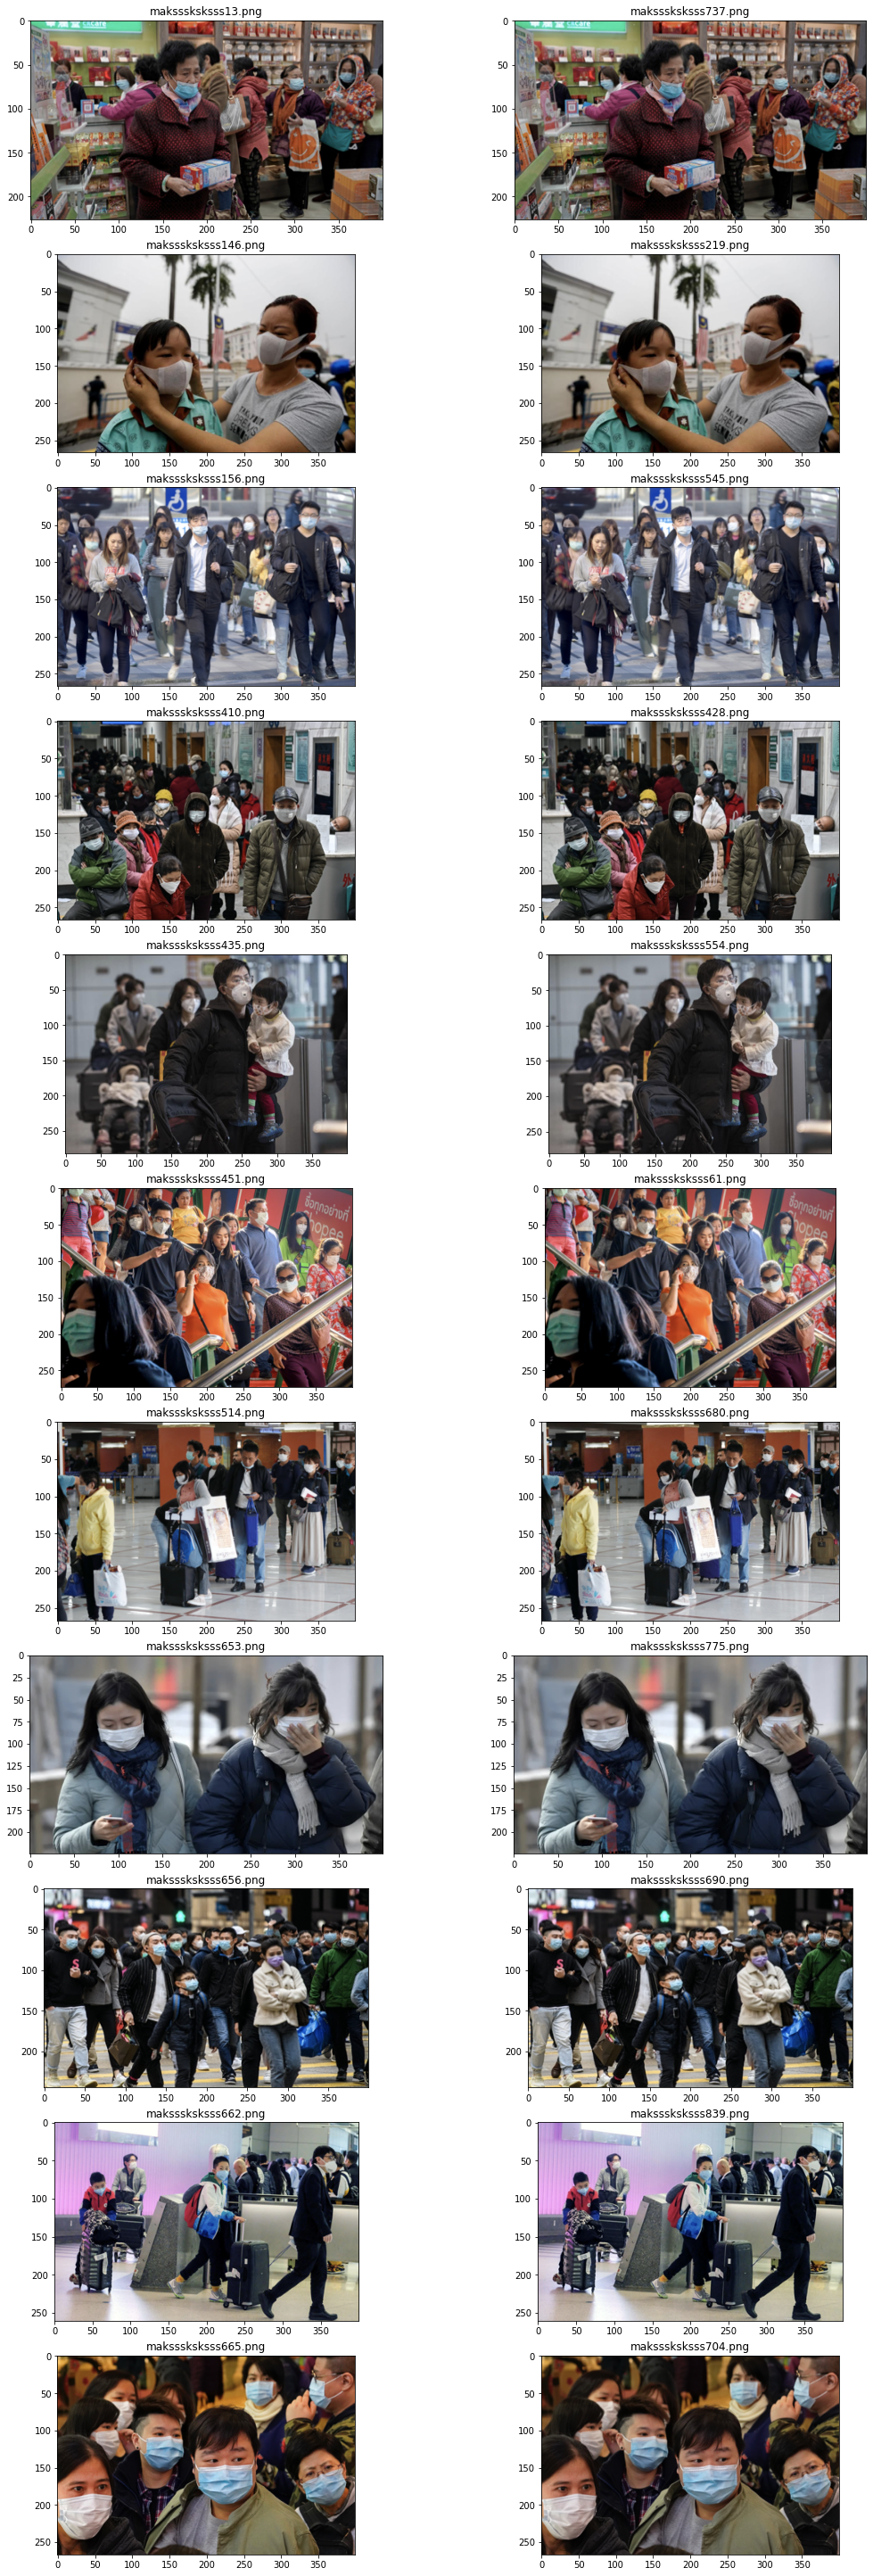

In [6]:
# print the images to visually confirmation
# that there is duplicated imaged
# The list is based on the results from the previous cell
duplicated_list1 = [
    "maksssksksss13.png",
    "maksssksksss146.png",
    "maksssksksss156.png",
    "maksssksksss410.png",
    "maksssksksss435.png",
    "maksssksksss451.png",
    "maksssksksss514.png",
    "maksssksksss653.png",
    "maksssksksss656.png",
    "maksssksksss662.png",
    "maksssksksss665.png"
]
duplicated_list2 = [
    "maksssksksss737.png",
    "maksssksksss219.png",
    "maksssksksss545.png",
    "maksssksksss428.png",
    "maksssksksss554.png",
    "maksssksksss61.png",
    "maksssksksss680.png",
    "maksssksksss775.png",
    "maksssksksss690.png",
    "maksssksksss839.png",
    "maksssksksss704.png"
]

ncols = 2
nrows = len(duplicated_list1)
fig, ax = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(15, 40), constrained_layout=True
)
for i in range(nrows):
    img_arr = cv2.imread(IMG_PATH + duplicated_list1[i])
    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
    ax[i, 0].imshow(img_arr)
    ax[i, 0].set_title(duplicated_list1[i])

    img_arr = cv2.imread(IMG_PATH + duplicated_list2[i])
    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
    ax[i, 1].imshow(img_arr)
    ax[i, 1].set_title(duplicated_list2[i])

In [7]:
# delete duplicated
for file in duplicated_list1:
    os.remove(IMG_PATH + file)
    os.remove(ANNOT_PATH + file.replace("png", "xml"))

In [8]:
# check number of files, should be 853 - 11 = 842
print(f"Number of image files: {len(os.listdir(IMG_PATH))}")
print(f"Number of annotation files:  {len(os.listdir(ANNOT_PATH))}")

Number of image files: 842
Number of annotation files:  842


## Exploratory Data Analysis

- Check image files

The images come in various sizes and formats, such as portrait and landscape. It's interesting how the author of the image collection included a variety of perspectives of a person wearing a mask. This will help to generalize our model and to recognize a mask-wearing individual.

In [9]:
# define function
def show_img(img_name):
    """Take input file directory and plot the image"""
    img_name = IMG_PATH + img_name
    img_arr = cv2.imread(img_name)
    # cv2 reads image and store in BGR, while matplotlib reads in RGB
    # cv2.cvtColor will convert in to correct channel format
    img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
    plt.imshow(img_arr)
    return


def show_more_img(img_name_list):
    """take a list of image files directory and plot the images"""
    path_lst = [IMG_PATH + img_file for img_file in img_name_list]
    nrow = len(path_lst)
    figsize = (10, 5 * nrow)
    fig, ax = plt.subplots(
        nrows=nrow, ncols=1, figsize=figsize, constrained_layout=True
    )

    for i in range(nrow):
        img_arr = cv2.imread(path_lst[i])
        # cv2 reads image and store in BGR, while matplotlib reads in RGB
        # cv2.cvtColor will convert in to correct channel format
        img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
        ax[i].imshow(img_arr)

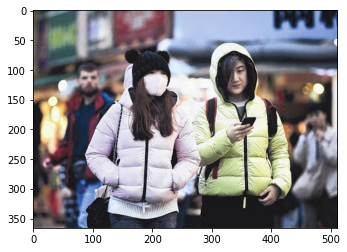

In [10]:
# Check image file
show_img(os.listdir(IMG_PATH)[0])

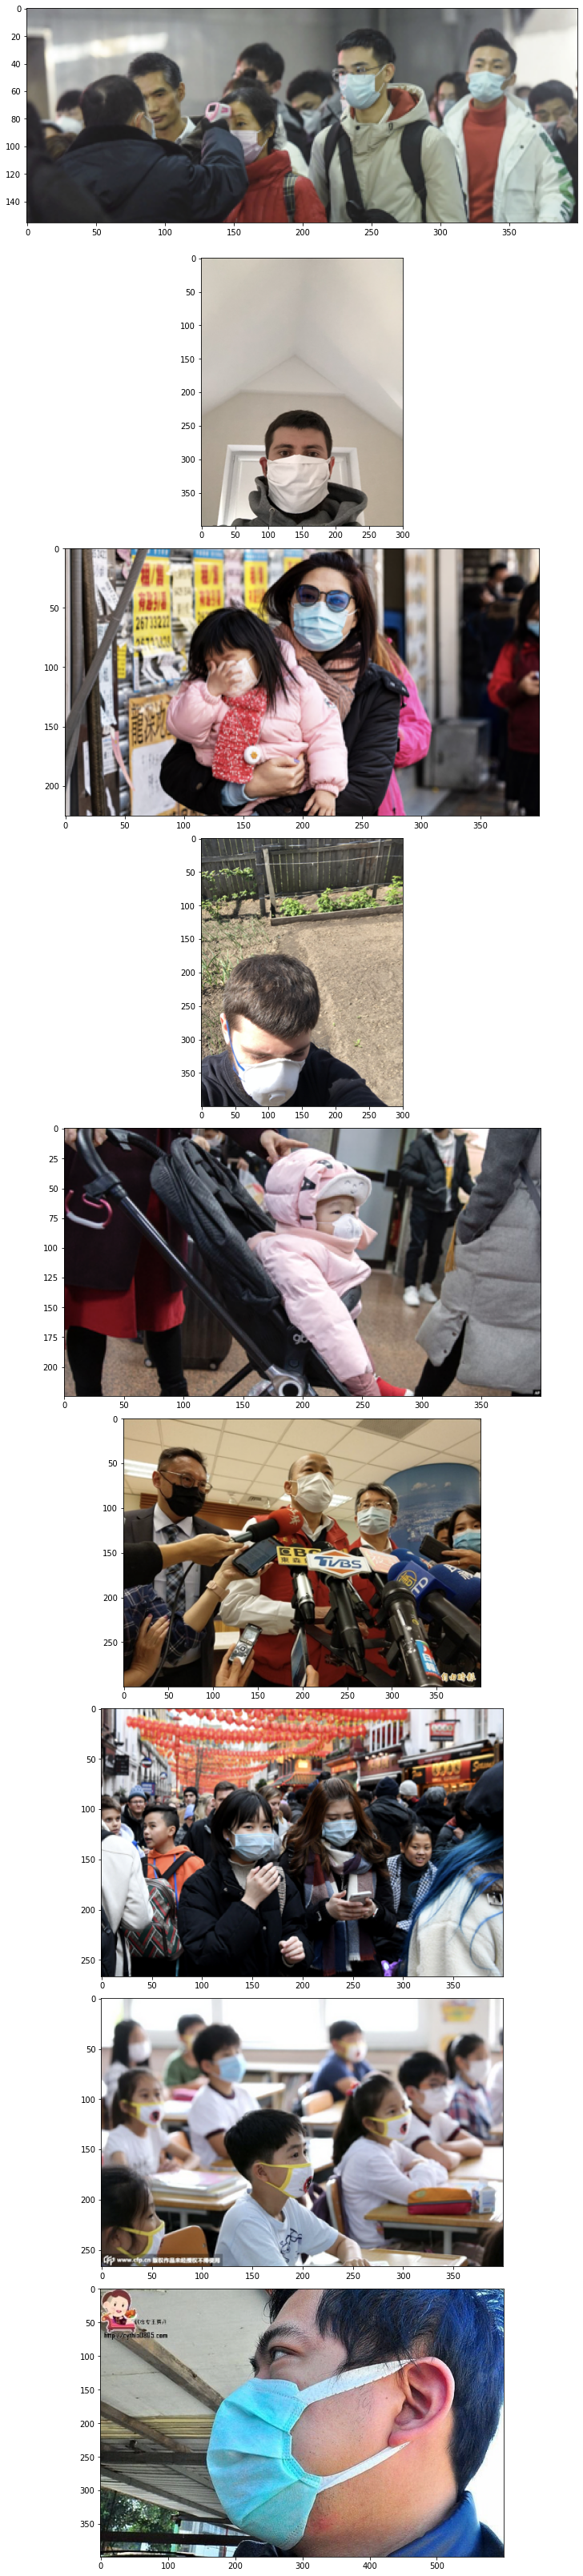

In [11]:
# Check more images
show_more_img(os.listdir(IMG_PATH)[1:10])

- Check annotation files

From printed annotation file below e.g. `maksssksksss0.xml`, we can find the information below:

- **image size**: the image file is 512 (width) by 366 (height) with 3 colour channels 
- **location of bounding boxes**: 3 bounding boxes described by x_min, x_max, y_min, y_max
- **class**: classes of each bounded boxes (e.g. with_mask, without_mask)

Bounding boxes are a type of rectangular label that identify where an object is in a picture. The center point of the x, y coordinate with a combination of height and width information can be used to characterize them.

In [12]:
x = etree.parse(ANNOT_PATH + annot_list[0])
print(etree.tostring(x, encoding="unicode", pretty_print=True))

<annotation>
    <folder>images</folder>
    <filename>maksssksksss0.png</filename>
    <size>
        <width>512</width>
        <height>366</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>79</xmin>
            <ymin>105</ymin>
            <xmax>109</xmax>
            <ymax>142</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>185</xmin>
            <ymin>100</ymin>
            <xmax>226</xmax>
            <ymax>144</ymax>
        </bndbox>
    </object>
    <object>
        <name>without_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</t

- (edit)

In [13]:
# extracting information from xml and save into dictionary
information = {
    "xmin": [],
    "ymin": [],
    "xmax": [],
    "ymax": [],
    "label": [],
    "width": [],
    "height": [],
    "images": [],
}

for annotation in glob.glob(ANNOT_PATH + "*.xml"):
    tree = ElementTree.parse(annotation)

    for element in tree.iter():
        if "filename" in element.tag:
            filename = element.text

        if "size" in element.tag:
            for attribute in list(element):
                if "width" in attribute.tag:
                    width = int(attribute.text)
                if "height" in attribute.tag:
                    height = int(attribute.text)

        if "object" in element.tag:
            for attribute in list(element):

                if "name" in attribute.tag:
                    name = attribute.text
                    information["label"] += [name]
                    information["width"] += [width]
                    information["height"] += [height]
                    information["images"] += [filename]

                if "bndbox" in attribute.tag:
                    for value in list(attribute):
                        if "xmin" in value.tag:
                            xmin = int(value.text)
                            information["xmin"] += [xmin]
                        if "ymin" in value.tag:
                            ymin = int((value.text))
                            information["ymin"] += [ymin]
                        if "xmax" in value.tag:
                            xmax = int((value.text))
                            information["xmax"] += [xmax]
                        if "ymax" in value.tag:
                            ymax = int((value.text))
                            information["ymax"] += [ymax]

In [14]:
# save in dataframe
df = pd.DataFrame(information)
df["annotation"] = df["images"].apply(lambda x: x.split(".")[0] + ".xml")
df = df.sort_values("images").reset_index(drop=True)

In [15]:
# print dataframe
df.head()

xmin  ymin  xmax  ymax         label  width  height             images  \
0    79   105   109   142  without_mask    512     366  maksssksksss0.png   
1   185   100   226   144     with_mask    512     366  maksssksksss0.png   
2   325    90   360   141  without_mask    512     366  maksssksksss0.png   
3   321    34   354    69     with_mask    400     156  maksssksksss1.png   
4   224    38   261    73     with_mask    400     156  maksssksksss1.png   

          annotation  
0  maksssksksss0.xml  
1  maksssksksss0.xml  
2  maksssksksss0.xml  
3  maksssksksss1.xml  
4  maksssksksss1.xml

In [16]:
# function to cropped faces based on bounding boxes
def cropping(df):
    """crop the images of the faces based on the bounding box"""
    os.makedirs(CROPPED_PATH, exist_ok=True)
    for i in range(len(df)):
        img_path = IMGS_PATH + df["images"].iloc[i]
        img_arr = cv2.imread(img_path)
        cropped_image = re.sub(
            "\.(?<=\.).+", "-" + str(i), df["images"].iloc[i]
        )

        xmin = df["xmin"].iloc[i]
        ymin = df["ymin"].iloc[i]
        xmax = df["xmax"].iloc[i]
        ymax = df["ymax"].iloc[i]

        cropped_arr = img_arr[ymin:ymax, xmin:xmax]
        cropped_img_path = CROPPED_PATH + cropped_image + ".jpg"
        cv2.imwrite(cropped_img_path, cropped_arr)

- Image distribution

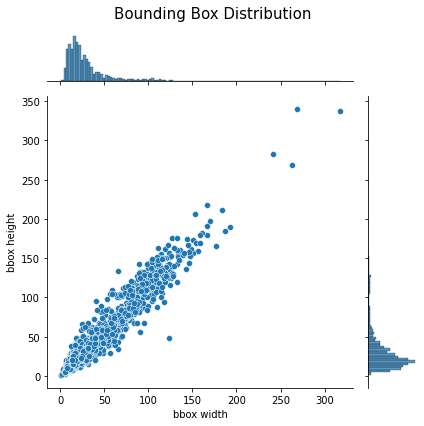

In [17]:
# plot distribution of the bounding boxes
plot = sns.jointplot(x=(df.xmax - df.xmin), y=(df.ymax - df.ymin))
plot.set_axis_labels("bbox width", "bbox height")
plot.fig.suptitle("Bounding Box Distribution", fontsize=15)
plt.tight_layout()

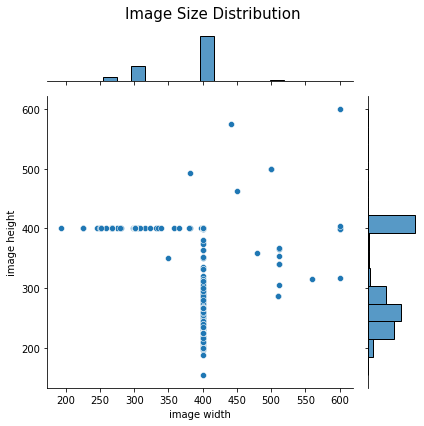

In [18]:
# plot distribution of image size
plot = sns.jointplot(
    x=df.groupby("images").mean()["width"],
    y=df.groupby("images").mean()["height"],
)
plot.set_axis_labels("image width", "image height")
plot.fig.suptitle("Image Size Distribution", fontsize=15)
plt.tight_layout()

- Class distribution

We have an unbalanced dataset. Among the input images, 79% are wearing mask, 18% are not wearing mask and only 3% are wearing it improperly.

In [19]:
# check class distribution
df.label.value_counts(normalize=True)

with_mask                0.792843
without_mask             0.177923
mask_weared_incorrect    0.029234
Name: label, dtype: float64

In the next notebook, we will start the modeling on Google Colab.

**References:**
- https://www.kaggle.com/datasets/andrewmvd/face-mask-detection
- https://www.hindawi.com/journals/wcmc/2022/1536318/
- https://www.johnsoncontrols.com/insights/2021/thought-leadership/understanding-face-mask-detection-technology
- https://github.com/siowcm/Captone_Mask_Up